possible_configurations = level_count^segment_count = 51^30 = 1.7e+51
Minimum energy: -22.83684458920654
y-displacements (actual values): [np.float64(0.0), np.float64(0.0), np.float64(0.0011999999999999997), np.float64(0.0031999999999999997), np.float64(0.005600000000000001), np.float64(0.008000000000000002), np.float64(0.0096), np.float64(0.01), np.float64(0.009200000000000002), np.float64(0.0072), np.float64(0.004), np.float64(0.0), np.float64(-0.004), np.float64(-0.0072), np.float64(-0.0092), np.float64(-0.01), np.float64(-0.009600000000000001), np.float64(-0.008), np.float64(-0.0052), np.float64(-0.001599999999999999), np.float64(0.002400000000000001), np.float64(0.006), np.float64(0.0088), np.float64(0.01), np.float64(0.01), np.float64(0.0088), np.float64(0.006400000000000001), np.float64(0.0028000000000000004), np.float64(-0.001599999999999999), np.float64(-0.006), np.float64(-0.01)]


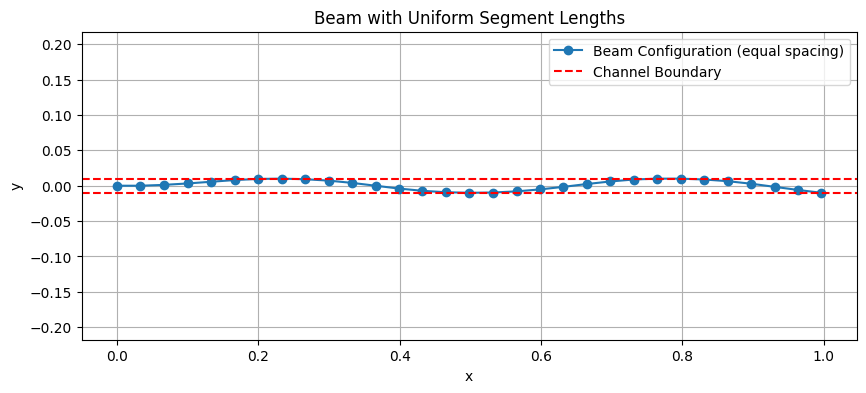

In [26]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

# --- Plotting function (added for completeness) ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_beam(y_displacements):
    y_displacements = np.asarray(y_displacements)
    ds = beam_length / segment_count

    # Step 1: Approximate x_coords using current method
    y_diffs = np.diff(y_displacements)
    x_diffs = np.sqrt(np.maximum(ds**2 - y_diffs**2, 0))
    x_coords = np.concatenate([[0], np.cumsum(x_diffs)])

    # Step 2: Compute cumulative arclength
    dx = np.diff(x_coords)
    dy = np.diff(y_displacements)
    arc_lengths = np.concatenate([[0], np.cumsum(np.sqrt(dx**2 + dy**2))])

    # Step 3: Interpolate to get equally spaced points
    uniform_s = np.linspace(0, arc_lengths[-1], segment_count + 1)
    x_interp = interp1d(arc_lengths, x_coords, kind='linear')
    y_interp = interp1d(arc_lengths, y_displacements, kind='linear')

    x_uniform = x_interp(uniform_s)
    y_uniform = y_interp(uniform_s)

    # Step 4: Plot
    plt.figure(figsize=(10, 4))
    plt.plot(x_uniform, y_uniform, 'o-', label='Beam Configuration (equal spacing)')
    plt.axhline(y=channel_height_half, color='r', linestyle='--', label='Channel Boundary')
    plt.axhline(y=-channel_height_half, color='r', linestyle='--')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Beam with Uniform Segment Lengths')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.ylim(-channel_height_half * 1.1, channel_height_half * 1.1)
    plt.show()


# --- Parameters ---
E = 1
I_beam = 1 # Renamed to avoid confusion with loop variable I
beam_length = 1
segment_count = 30
channel_height_half = 0.01
level_count = 50
if level_count % 2 != 1:
    level_count += 1 # Ensure odd for a true center
Tx = -500 # positive for tension, negative for compression
N = segment_count # T
L = level_count # S
s, ds = np.linspace(0, beam_length, segment_count, retstep=True)
possible_y = np.linspace(-channel_height_half, channel_height_half, level_count)

print(f"possible_configurations = level_count^segment_count = {level_count}^{segment_count} = {level_count**segment_count:.1e}")

# Calculate the index for the center of the channel
Ib = int((level_count - 1) / 2)

# Energy function between two states (I,J) -> (J,K)
def g(state1_y, state2_y):
    I_val, J_val = state1_y
    _, K_val = state2_y
    try:
        theta1 = np.arcsin((J_val - I_val) / ds)
        theta2 = np.arcsin((K_val - J_val) / ds)

        # Bending energy: typically proportional to curvature squared
        bend = E * I_beam * ((theta2 - theta1) / ds)**2
        stretch = Tx * (1 - np.cos(theta1))
        
        return bend + stretch
    except ValueError:
        # This occurs if (J_val - I_val) / ds or (K_val - J_val) / ds is outside [-1, 1]
        return np.inf  # arcsin domain error - represents an unphysical configuration

# Initialization
# C stores the minimum cost to reach state (J, K) at segment m
C = {}
# survivor stores the *predecessor* index I that led to the minimum cost for (J, K) at segment m
survivor = {}

# Initialize for the first segment (m=1)
# The state is (I, J), representing the segment from y_I to y_J
# We are considering a path of N segments, which means N+1 points.
# For m=1, we consider the first segment from point s[0] to s[1].
# The starting point is fixed at Ib (center of channel).
for I_idx, J_idx in itertools.product(range(L), repeat=2):
    if I_idx == J_idx == Ib:
        C[(I_idx, J_idx, 1)] = 0 # Cost to reach (Ib, Ib) at segment 1 is 0
        survivor[(I_idx, J_idx, 1)] = None # No predecessor for the first segment
    else:
        C[(I_idx, J_idx, 1)] = np.inf
        survivor[(I_idx, J_idx, 1)] = None

# Viterbi forward pass
# m goes from 2 to N (N segments means points up to N+1)
for m in range(2, N + 1):
    for J_idx, K_idx in itertools.product(range(L), repeat=2):
        best_cost = np.inf
        best_prev_I_idx = None # Store the index of the best previous state

        # Iterate over all possible previous y-levels (I)
        for I_idx in range(L):
            prev_state_key = (I_idx, J_idx, m - 1)
            prev_cost = C.get(prev_state_key, np.inf)

            if prev_cost == np.inf:
                continue # Skip if the previous state is unreachable

            # Calculate transition cost from (I -> J) to (J -> K)
            trans_cost = g((possible_y[I_idx], possible_y[J_idx]), (possible_y[J_idx], possible_y[K_idx]))
            total_cost = prev_cost + trans_cost

            if total_cost < best_cost:
                best_cost = total_cost
                best_prev_I_idx = I_idx # Store the predecessor I_idx

        C[(J_idx, K_idx, m)] = best_cost
        survivor[(J_idx, K_idx, m)] = best_prev_I_idx # Store only the predecessor index

# Backtrace to find the optimal path
min_cost = np.inf
best_final_key = None

# Find the minimum cost among all possible (J, K) states at the last segment N
for J_idx, K_idx in itertools.product(range(L), repeat=2):
    current_key = (J_idx, K_idx, N)
    cost = C.get(current_key, np.inf)
    if cost < min_cost:
        min_cost = cost
        best_final_key = current_key

if best_final_key is None or min_cost == np.inf:
    print("No valid path found (possibly all paths lead to infinite cost).")
else:
    # Reconstruct the path by backtracing
    path_indices = []
    current_J_idx, current_K_idx, current_m = best_final_key

    # Start from the last segment's end (K) and start (J)
    path_indices.append(current_K_idx)
    path_indices.append(current_J_idx)

    # Backtrace through segments from N down to 2
    for m_step in range(N, 1, -1):
        prev_I_idx = survivor[(current_J_idx, current_K_idx, m_step)]
        if prev_I_idx is None: # Should not happen if a valid path exists
            break
        path_indices.append(prev_I_idx)
        current_K_idx = current_J_idx # Current K becomes next J
        current_J_idx = prev_I_idx    # Current J becomes next I

    # The path is built in reverse order, so reverse it
    # The path should be [y_0, y_1, y_2, ..., y_N] where y_m is the displacement at s_m
    # The Viterbi states are (y_{m-2}, y_{m-1}) for segment m-1 to (y_{m-1}, y_m) for segment m
    # So if the final state is (J, K, N), the path points are ... I, J, K.
    # The reconstruction needs to ensure it gets all N+1 points correctly.

    # Correct backtrace reconstruction for N+1 points:
    # Starting from the final state (J, K, N)
    final_J_idx, final_K_idx, _ = best_final_key
    reconstructed_y_indices = [final_K_idx] # The last point
    reconstructed_y_indices.append(final_J_idx) # The second to last point

    current_J_trace = final_J_idx
    current_K_trace = final_K_idx

    for m_trace in range(N, 1, -1):
        # The stored predecessor `survivor[(prev_J_idx, current_K_idx, m_trace)]`
        # is the `I_idx` that led to the state `(current_J_idx, current_K_idx)` at segment `m_trace`.
        # So we need to query based on the state at `m_trace` which is `(prev_I_idx, current_J_trace, m_trace-1)`
        # and its cost at `m_trace-1` was `C[(prev_I_idx, current_J_trace, m_trace-1)]`
        # The stored `survivor` at `(current_J_trace, current_K_trace, m_trace)` is the `prev_I_idx`.
        prev_I_trace = survivor[(current_J_trace, current_K_trace, m_trace)]
        if prev_I_trace is None:
            # This should only happen if the path was indeed disconnected or started without a proper predecessor
            # (e.g., if the initial state for m=1 wasn't correctly set as None or handled)
            break
        reconstructed_y_indices.append(prev_I_trace)
        current_K_trace = current_J_trace
        current_J_trace = prev_I_trace

    reconstructed_y_indices.reverse() # Path is built backwards

    y_displacements = [possible_y[i] for i in reconstructed_y_indices]
    
    # Generate s-coordinates for plotting (N+1 points for N segments)
    s_coords_for_plot = np.linspace(0, beam_length, N + 1)

    # Output
    print("Minimum energy:", min_cost)
    # The path stored in survivor now only has predecessor indices, not full paths.
    # So we print the reconstructed y-displacements directly.
    print("y-displacements (actual values):", y_displacements)
    # print("Best path (index pairs):", best_path) # No longer applicable directly

    # Plotting
    plot_beam(y_displacements)